In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from flows import NormalRW, DFlow, NVPFlow, LogNormal, GVAR, phase,\
Normal, floatX, MVNormal, MVNormalRW, Linear, LinearChol
import flows

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky
import math
from flows.models import VARmodel

np.random.seed(1234)
tf.set_random_seed(1234)

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
# device_lib.list_local_devices()

In [3]:
tf.trainable_variables()

[]

In [4]:
!ls CDATA

AUS.csv  FRA.csv  GBR.csv  SYNTH.csv


In [5]:
ccodes = ['FRA', 'AUS', 'GBR']
datas = ['./CDATA/{}.csv'.format(x) for x in ccodes]

In [6]:
datas = [pd.read_csv(x, index_col='VARIABLE').iloc[:,:-1] for x in datas]
columns = [data.columns.values.astype('float32') for data in datas]
datas = [data.values.astype(floatX) for data in datas]

In [7]:
[data.shape for data in datas]

[(4, 194), (4, 202), (4, 162)]

In [8]:
max_year = 0

In [9]:
scaler = 0.
for i, data in enumerate(datas):
    stds = (data[:,1:] - data[:,:-1]).std(axis=1)
    print(stds)
    scaler = scaler + stds
    datas[i] = data
print('---')
scaler /= len(datas)
for i in range(len(datas)):
    datas[i] /= scaler[:,np.newaxis]
    data = datas[i]
    stds = (data[:,1:] - data[:,:-1]).std(axis=1)
    print(stds)
    data = np.concatenate([data[:,1:], data[:,:-1]], axis=0)
    data = pd.DataFrame(data, columns=columns[i][1:])
    max_year = max(max_year, max(columns[i][1:]))
    datas[i] = data

[0.00575565 0.9293154  0.00505212 0.03008741]
[0.01346097 1.6949322  0.01075971 0.06685966]
[0.01071561 0.98235863 0.01054417 0.02619566]
---
[0.57686794 0.77301115 0.57506233 0.73298854]
[1.3491448 1.409856  1.2247355 1.6288338]
[1.0739871  0.81713253 1.2002009  0.638178  ]


In [10]:
from flows.models import VARmodel

In [11]:
country_data = {c:d for c,d in zip(ccodes, datas) if c == 'FRA'}

In [12]:
# global_inf = DFlow([LinearChol(4*(4*2+1), name='lc')], init_sigma=0.01, num_samples=1024)

# global_prior = Normal(shape=None, sigma=1., name='global_prior').logdens(global_inf.output, reduce=False)
# global_prior = tf.reduce_sum(global_prior, axis=-1)
# tf.add_to_collection('logdensities', global_inf.logdens)
# tf.add_to_collection('priors', global_prior)

In [13]:
for c, d in country_data.items():
    model = VARmodel(d, name='{}_model'.format(c), num_samples=1024,
                      var_dim=4, current_year=2000.)#, mu=global_inf.output[:,tf.newaxis])
    for l in model.logdensities:
        tf.add_to_collection('logdensities', l)
    for p in model.priors:
        tf.add_to_collection('priors', p)

<dtype: 'float32'>
ldiag logdens Tensor("FRA_model/rw_priors/PWalk_inf/flows/sub_1:0", shape=(1024,), dtype=float32)
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
Prior disp: [0.286496   0.38744742 0.2863046  0.36744273]
<dtype: 'float32'>
preds Tensor("FRA_model/strided_slice_3:0", shape=(193, 1024, 4), dtype=float32)
Tensor("FRA_model/loglikelihood/strided_slice_2:0", shape=(192, 1024, 4), dtype=float32)
<dtype: 'float32'>
blogl Tensor("FRA_model/loglikelihood/strided_slice_14:0", shape=(?, 1024), dtype=float32)
logl Tensor("FRA_model/loglikelihood/Sum_1:0", shape=(1024,), dtype=float32)


In [14]:
priors = tf.get_collection('priors')
logdensities = tf.get_collection('logdensities')

In [15]:
priors = priors[:-1]
priors

[<tf.Tensor 'FRA_model/rw_priors/PWalk_inf/flows/Sum_2:0' shape=(1024,) dtype=float32>,
 <tf.Tensor 'FRA_model/PWalk_prior/pwalk_prior_ld:0' shape=(1024,) dtype=float32>,
 <tf.Tensor 'FRA_model/obsrv_prior/Sum:0' shape=(1024,) dtype=float32>]

In [16]:
prior = tf.add_n(priors)
logdensity = tf.add_n(logdensities)
print(prior, logdensity)

kl = logdensity - prior
kl = tf.reduce_mean(kl)
kl /= 36*160

lr = tf.constant(0.002)
def build_upd(lr):
    vs = tf.trainable_variables()
    gs = tf.gradients(kl, vs)
    checks = [tf.check_numerics(x, 'NAN found in {}'.format(x.op.name)) for x in gs if x is not None]
    with tf.control_dependencies(checks):
        main_op = tf.train.AdamOptimizer(lr).apply_gradients(zip(gs,vs))
    return main_op

main_op = build_upd(lr)

Tensor("AddN:0", shape=(1024,), dtype=float32) Tensor("AddN_1:0", shape=(1024,), dtype=float32)


In [17]:
graph = tf.get_default_graph()
rw_prior = graph.get_tensor_by_name('FRA_model/PWalk_prior/pwld_prereduce:0')
tf.summary.scalar('rw_prior', tf.reduce_mean(rw_prior))

KeyError: "The name 'FRA_model/PWalk_prior/pwld_prereduce:0' refers to a Tensor which does not exist. The operation, 'FRA_model/PWalk_prior/pwld_prereduce', does not exist in the graph."

In [18]:
kls = tf.summary.scalar('KLd', kl)
summary = tf.summary.merge_all()

In [19]:
# model.PWalk.diag.eval().mean(axis=0)

In [20]:
# model.PWalk.diag.eval().std(axis=0)

In [21]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

In [22]:
init.run()

In [23]:
global_inf.output.eval().mean(axis=0)

NameError: name 'global_inf' is not defined

In [24]:
output = model.outputs.eval()

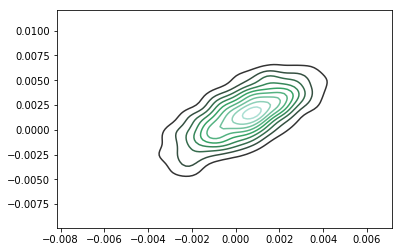

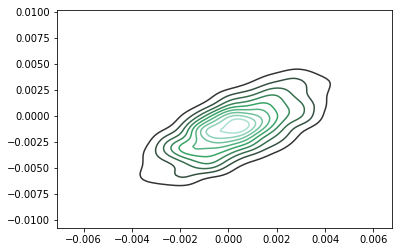

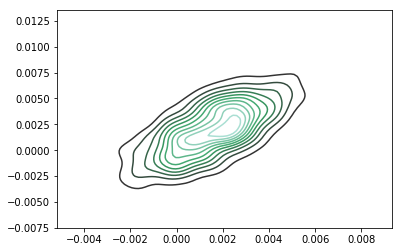

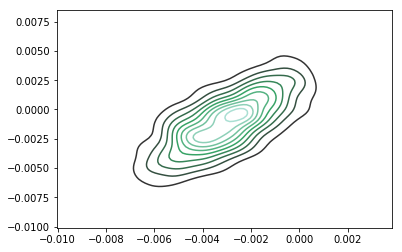

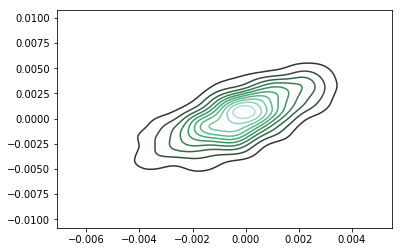

In [25]:
for i in range(5):
    sns.kdeplot(output[:,2,i], output[:,5,i])
    plt.show()

In [26]:
output.dtype

dtype('float32')

In [27]:
model.PWalk.diag.eval().mean(axis=0)

array([0.00249998, 0.00249921, 0.0025003 , 0.00250005, 0.00249985,
       0.00250073, 0.0025003 , 0.00249919, 0.00250044, 0.00250021,
       0.00249983, 0.00250093, 0.00249892, 0.00250009, 0.00250035,
       0.00249914, 0.00249985, 0.00250136, 0.00249849, 0.00250117,
       0.00249841, 0.00250103, 0.00250053, 0.00250039, 0.00250135,
       0.00250136, 0.00249866, 0.00250017, 0.00250033, 0.00249979,
       0.00249933, 0.00250103, 0.00249861, 0.00250047, 0.00250011,
       0.0025009 ], dtype=float32)

In [28]:
writer = tf.summary.FileWriter('/tmp/tfdbg/centralized-nodata-better-init-nogl')

In [29]:
epoch = 0

In [31]:
epoch

549

In [ ]:
for epoch in range(epoch, 100000):
    print(epoch)
    for step in range(10):
        sess.run(main_op)
    s, _ = sess.run([summary, main_op], {lr: 0.001})
    writer.add_summary(s, global_step=epoch)

849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868


In [ ]:
preds = model.preds.eval().mean(axis=1)[:50]

In [ ]:
true = model.data.eval()[0,:,:4][:50]

In [ ]:
preds.shape

In [ ]:
true.shape

In [ ]:
np.std(preds[:-1]-true[1:], axis=0)

In [ ]:
outputs = model.outputs.eval()
devs = outputs[:,1:] - outputs[:,:-1]
devs = np.reshape(devs, (-1,36))

In [ ]:
np.std(devs, axis=0)

In [ ]:
outputs.shape

In [ ]:
saver = tf.train.Saver()

In [ ]:
saver.save(sess, '/tmp/debug_save')

In [ ]:
graph = tf.get_default_graph()

In [ ]:
[x for x in graph.get_operations() if 'walk_distr' in x.name]

In [ ]:
writer.add_graph(graph)

In [ ]:
premu = graph.get_tensor_by_name('FRA_model/PWalk_prior/premu:0').eval()

In [ ]:
for i in range(5):
    sns.kdeplot(output[:,2,i], output[:,5,i])
    plt.show()

In [ ]:
tf.trainable_variables()

In [ ]:
graph.get_tensor_by_name('FRA_model/coef_rw_inference/VAR/mu:0').eval()

In [ ]:
preds = model.preds.eval().mean(axis=1)

In [ ]:
dd = model.data_raw.values[:4,:].T

In [ ]:
np.std(preds - dd, axis=0)

In [ ]:
graph = tf.get_default_graph()

In [ ]:
graph.get_tensor_by_name('FRA_model/PWalk_prior/pwalk_prior_ld:0').eval()

In [ ]:
kl.eval()

In [ ]:
diags = []
for _ in range(4000):
    d = model.PWalk.diag.eval().mean(axis=0)
    diags.append(d)
diags = np.mean(diags, axis=0)

In [ ]:
diags

In [ ]:
wsigmas = tf.sqrt(tf.diag_part(model.PWalk.sigma))

In [ ]:
wsigmas

In [ ]:
global_post=global_inf.output[0]

In [ ]:
ss = []
for _ in range(1000):
    ss.append(wsigmas.eval())
ss = np.array(ss)

In [ ]:
np.mean(ss,axis=0)

In [ ]:
ss.std(axis=0)

In [ ]:
sns.kdeplot(ss[:,4], ss[:,1])
plt.show()